In [12]:
import requests
import pandas as pd
import time
from fake_useragent import UserAgent

# 资金流向字段映射（根据实际API响应调整）
money_flow_mapping = {
    0: '日期',
    1: '主力净流入(元)',
    2: '小单净流入(元)',
    3: '中单净流入(元)',
    4: '大单净流入(元)',
    5: '超大单净流入(元)',
    6: '主力净流入占比(%)',
    7: '小单净流入占比(%)',
    8: '中单净流入占比(%)',
    9: '大单净流入占比(%)',
    10: '超大单净流入占比(%)',
    11: '收盘价',
    12: '涨跌幅(%)',
    13: '换手率(%)'
}

class EastMoneyDailyMoneyFlowFetcher:
    def __init__(self, stock_codes, days=5):
        self.ua = UserAgent()
        self.stock_codes = stock_codes
        self.days = days
        
    def fetch_single(self, stock_code):
        headers = {
            "User-Agent": self.ua.random,
            "Referer": "https://data.eastmoney.com/"
        }
        
        # 构造secid参数
        market = "1" if stock_code.startswith(('6', '5')) else "0"
        secid = f"{market}.{stock_code}"
        
        url = (
            f"https://push2his.eastmoney.com/api/qt/stock/fflow/daykline/get?"
            f"secid={secid}"
            f"&fields1=f1,f2,f3,f7"
            f"&fields2=f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64"
            f"&klt=101"  # 日线数据
            f"&lmt={self.days}"
            f"&ut=b2884a393a59ad64002292a3e90d46a5"
        )
        
        try:
            response = requests.get(url, headers=headers, timeout=10)
            json_data = response.json()
            
            if json_data.get("rc") != 0 or not json_data.get("data"):
                print(f"Warning: No data for {stock_code}")
                return None
                
            data = json_data["data"]
            klines = data["klines"]
            
            if not klines:
                return None
                
            # 处理数据
            all_data = []
            for line in klines:
                values = line.split(',')
                if len(values) != len(money_flow_mapping):
                    print(f"数据列数不匹配: 预期{len(money_flow_mapping)}列，实际{len(values)}列")
                    continue
                row_data = {desc: values[i] for i, desc in money_flow_mapping.items()}
                row_data["股票代码"] = stock_code
                row_data["股票名称"] = data.get("name", "")
                all_data.append(row_data)
                
            df = pd.DataFrame(all_data)
            return df
            
        except Exception as e:
            print(f"Error fetching {stock_code}: {e}")
            return None
    
    def fetch_all(self):
        all_data = []
        for code in self.stock_codes:
            print(f"Fetching daily money flow for: {code}")
            df = self.fetch_single(code)
            if df is not None:
                all_data.append(df)
            time.sleep(1)  # 防止触发限速
        return pd.concat(all_data, ignore_index=True) if all_data else None


# 使用示例
if __name__ == "__main__":
    stock_list = ['002631']
    
    fetcher = EastMoneyDailyMoneyFlowFetcher(stock_list, days=10)
    money_flow_df = fetcher.fetch_all()
    
    if money_flow_df is not None:
        print("\n资金流向数据：")
        # 转换数值类型
        numeric_cols = [col for col in money_flow_df.columns 
                       if col not in ['日期', '股票代码', '股票名称'] and not col.endswith('占比(%)')]
        percent_cols = [col for col in money_flow_df.columns if col.endswith('占比(%)')]
        
        money_flow_df[numeric_cols] = money_flow_df[numeric_cols].apply(pd.to_numeric, errors='coerce')
        money_flow_df[percent_cols] = money_flow_df[percent_cols].apply(pd.to_numeric, errors='coerce')
        
        # 格式化显示
        pd.set_option('display.max_columns', None)
        pd.set_option('display.float_format', '{:,.2f}'.format)
        print(money_flow_df)
        
        # 保存到CSV
        money_flow_df.to_csv("daily_money_flow.csv", index=False, encoding='utf_8_sig')
        print("\n数据已保存到 daily_money_flow.csv")
        
        # 分析主力资金动向
        if not money_flow_df.empty:
            for code in stock_list:
                stock_data = money_flow_df[money_flow_df['股票代码'] == code]
                if not stock_data.empty:
                    print(f"\n{code} 主力资金分析：")
                    print(f"近{len(stock_data)}日主力净流入总额: {stock_data['主力净流入(元)'].sum():,.2f}元")
                    print(f"最大单日净流入: {stock_data['主力净流入(元)'].max():,.2f}元")
                    print(f"最小单日净流入: {stock_data['主力净流入(元)'].min():,.2f}元")
                    print(f"平均每日净流入: {stock_data['主力净流入(元)'].mean():,.2f}元")
    else:
        print("未能获取资金流向数据")

Fetching daily money flow for: 002631

资金流向数据：
           日期       主力净流入(元)      小单净流入(元)      中单净流入(元)      大单净流入(元)  \
0  2025-04-23  -9,382,548.00 -1,875,625.00 11,258,174.00 -9,112,559.00   
1  2025-04-24 -18,845,472.00  7,568,624.00 11,276,848.00 -5,278,176.00   
2  2025-04-25  -7,948,530.00  6,067,472.00  1,881,058.00 -6,841,970.00   
3  2025-04-28 -11,437,784.00  8,357,338.00  3,080,447.00  1,666,187.00   
4  2025-04-29 -11,840,282.00  9,173,250.00  2,667,032.00 -9,981,322.00   
5  2025-04-30   7,628,489.00 -8,149,927.00    521,438.00  7,028,381.00   
6  2025-05-06  -2,501,403.00  1,830,736.00    670,667.00   -256,144.00   
7  2025-05-07   3,138,606.00 -2,003,894.00 -1,134,712.00  2,136,012.00   
8  2025-05-08   6,568,809.00 -1,835,461.00 -4,733,349.00  5,609,270.00   
9  2025-05-09   5,237,043.00 -5,016,359.00   -220,682.00  7,379,948.00   

       超大单净流入(元)  主力净流入占比(%)  小单净流入占比(%)  中单净流入占比(%)  大单净流入占比(%)  超大单净流入占比(%)  \
0    -269,989.00       -6.28       -1.26        7.54     

In [15]:
money_flow_df

,日期,主力净流入(元),小单净流入(元),中单净流入(元),大单净流入(元),超大单净流入(元),主力净流入占比(%),小单净流入占比(%),中单净流入占比(%),大单净流入占比(%),超大单净流入占比(%),收盘价,涨跌幅(%),换手率(%),股票代码,股票名称
0,2025-04-23,"-9,382,548.00","-1,875,625.00","11,258,174.00","-9,112,559.00","-269,989.00",-6.28,-1.26,7.54,-6.10,-0.18,4.69,-1.88,0.00,002631,德尔未来
1,2025-04-24,"-18,845,472.00","7,568,624.00","11,276,848.00","-5,278,176.00","-13,567,296.00",-12.40,4.98,7.42,-3.47,-8.93,4.51,-3.84,0.00,002631,德尔未来
2,2025-04-25,"-7,948,530.00","6,067,472.00","1,881,058.00","-6,841,970.00","-1,106,560.00",-9.37,7.15,2.22,-8.07,-1.30,4.51,0.00,0.00,002631,德尔未来
3,2025-04-28,"-11,437,784.00","8,357,338.00","3,080,447.00","1,666,187.00","-13,103,971.00",-8.46,6.18,2.28,1.23,-9.69,4.31,-4.43,0.00,002631,德尔未来
4,2025-04-29,"-11,840,282.00","9,173,250.00","2,667,032.00","-9,981,322.00","-1,858,960.00",-15.93,12.34,3.59,-13.43,-2.50,4.26,-1.16,0.00,002631,德尔未来
5,2025-04-30,"7,628,489.00","-8,149,927.00","521,438.00","7,028,381.00","600,108.00",10.31,-11.02,0.70,9.50,0.81,4.34,1.88,0.00,002631,德尔未来
6,2025-05-06,"-2,501,403.00","1,830,736.00","670,667.00","-256,144.00","-2,245,259.00",-3.07,2.25,0.82,-0.31,-2.76,4.44,2.30,0.00,002631,德尔未来
7,2025-05-07,"3,138,606.00","-2,003,894.00","-1,134,712.00","2,136,012.00","1,002,594.00",3.20,-2.04,-1.16,2.18,1.02,4.46,0.45,0.00,002631,德尔未来
8,2025-05-08,"6,568,809.00","-1,835,461.00","-4,733,349.00","5,609,270.00","959,539.00",7.03,-1.96,-5.06,6.00,1.03,4.53,1.57,0.00,002631,德尔未来
9,2025-05-09,"5,237,043.00","-5,016,359.00","-220,682.00","7,379,948.00","-2,142,905.00",4.03,-3.86,-0.17,5.68,-1.65,4.54,0.22,0.00,002631,德尔未来


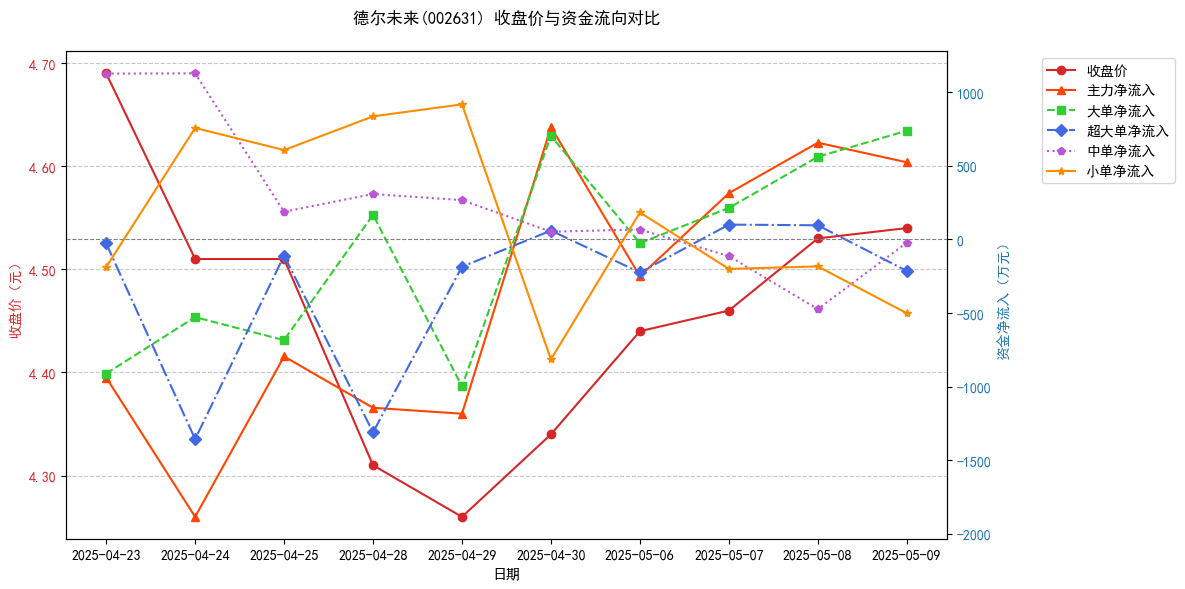

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rcParams

# 设置中文字体和图表样式
rcParams['font.sans-serif'] = ['SimHei']  # 显示中文
rcParams['axes.unicode_minus'] = False  # 显示负号

def plot_money_flow_comparison(money_flow_df):
    # 准备数据
    dates = money_flow_df['日期']
    close_prices = money_flow_df['收盘价'].astype(float)
    
    # 资金流向数据（单位转换为万元）
    main_net = money_flow_df['主力净流入(元)'].astype(float) / 10000
    large_net = money_flow_df['大单净流入(元)'].astype(float) / 10000
    super_net = money_flow_df['超大单净流入(元)'].astype(float) / 10000
    medium_net = money_flow_df['中单净流入(元)'].astype(float) / 10000
    small_net = money_flow_df['小单净流入(元)'].astype(float) / 10000

    # 创建画布和主坐标轴
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # 绘制收盘价曲线（左轴）
    color = 'tab:red'
    ax1.set_xlabel('日期')
    ax1.set_ylabel('收盘价（元）', color=color)
    line_close, = ax1.plot(dates, close_prices, color=color, marker='o', label='收盘价')
    ax1.tick_params(axis='y', labelcolor=color)
    
    # 设置左轴刻度
    ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    
    # 创建右轴（资金净流入）
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('资金净流入（万元）', color=color)
    
    # 绘制各类资金流向曲线（右轴）
    line_main, = ax2.plot(dates, main_net, color='#FF4500', linestyle='-', marker='^', label='主力净流入')
    line_large, = ax2.plot(dates, large_net, color='#32CD32', linestyle='--', marker='s', label='大单净流入')
    line_super, = ax2.plot(dates, super_net, color='#4169E1', linestyle='-.', marker='D', label='超大单净流入')
    line_medium, = ax2.plot(dates, medium_net, color='#BA55D3', linestyle=':', marker='p', label='中单净流入')
    line_small, = ax2.plot(dates, small_net, color='#FF8C00', linestyle='-', marker='*', label='小单净流入')
    
    # 设置右轴刻度
    ax2.tick_params(axis='y', labelcolor=color)
    
    # 添加零线参考
    ax2.axhline(0, color='gray', linestyle='--', linewidth=0.8)
    
    # 合并图例
    lines = [line_close, line_main, line_large, line_super, line_medium, line_small]
    ax1.legend(lines, [l.get_label() for l in lines], loc='upper left', bbox_to_anchor=(1.1, 1))
    
    # 设置标题和网格
    stock_name = money_flow_df['股票名称'].iloc[0] if '股票名称' in money_flow_df.columns else ''
    plt.title(f'{stock_name}({money_flow_df["股票代码"].iloc[0]}) 收盘价与资金流向对比', pad=20)
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    
    # 调整x轴标签
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # 显示图表
    plt.show()

# 使用示例
# 假设 money_flow_df 是您已经获取的DataFrame
if 'money_flow_df' in locals() or 'money_flow_df' in globals():
    plot_money_flow_comparison(money_flow_df)
else:
    print("请先获取资金流向数据（money_flow_df）")

In [ ]:
df = pd.read_csv("D:\小程序创业\JQDataCourse\股票K线数据_90天（2025.5.6）.csv", dtype={'股票代码': str})
stock_list = df['股票代码']
stock_list = list(set(stock_list))

In [31]:
import requests
import pandas as pd
import time
from fake_useragent import UserAgent

# 资金流向字段映射（根据实际API响应调整）
money_flow_mapping = {
    0: '日期',
    1: '主力净流入(元)',
    2: '小单净流入(元)',
    3: '中单净流入(元)',
    4: '大单净流入(元)',
    5: '超大单净流入(元)',
    6: '主力净流入占比(%)',
    7: '小单净流入占比(%)',
    8: '中单净流入占比(%)',
    9: '大单净流入占比(%)',
    10: '超大单净流入占比(%)',
    11: '收盘价',
    12: '涨跌幅(%)',
    13: '换手率(%)'
}

class EastMoneyDailyMoneyFlowFetcher:
    def __init__(self, stock_codes, days=5):
        self.ua = UserAgent()
        self.stock_codes = stock_codes
        self.days = days
        
    def fetch_single(self, stock_code):
        headers = {
            "User-Agent": self.ua.random,
            "Referer": "https://data.eastmoney.com/"
        }
        secid = stock_code
        
        url = (
            f"https://push2his.eastmoney.com/api/qt/stock/fflow/daykline/get?"
            f"secid={secid}"
            f"&fields1=f1,f2,f3,f7"
            f"&fields2=f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64"
            f"&klt=101"  # 日线数据
            f"&lmt={self.days}"
            f"&ut=b2884a393a59ad64002292a3e90d46a5"
        )
        
        try:
            response = requests.get(url, headers=headers, timeout=10)
            json_data = response.json()
            
            if json_data.get("rc") != 0 or not json_data.get("data"):
                print(f"Warning: No data for {stock_code}")
                return None
                
            data = json_data["data"]
            klines = data["klines"]
            
            if not klines:
                return None
                
            # 处理数据
            all_data = []
            for line in klines:
                values = line.split(',')
                if len(values) != len(money_flow_mapping):
                    print(f"数据列数不匹配: 预期{len(money_flow_mapping)}列，实际{len(values)}列")
                    continue
                row_data = {desc: values[i] for i, desc in money_flow_mapping.items()}
                row_data["股票代码"] = stock_code
                row_data["股票名称"] = data.get("name", "")
                all_data.append(row_data)
                
            df = pd.DataFrame(all_data)
            return df
            
        except Exception as e:
            print(f"Error fetching {stock_code}: {e}")
            return None
    
    def fetch_all(self):
        all_data = []
        for code in self.stock_codes:
            print(f"Fetching daily money flow for: {code}")
            df = self.fetch_single(code)
            if df is not None:
                all_data.append(df)
            # time.sleep(1)  # 防止触发限速
        return pd.concat(all_data, ignore_index=True) if all_data else None



        


In [32]:

fetcher = EastMoneyDailyMoneyFlowFetcher(stock_list, days=10)
money_flow_df = fetcher.fetch_all()

if money_flow_df is not None:
    print("\n资金流向数据：")
    # 转换数值类型
    numeric_cols = [col for col in money_flow_df.columns 
                    if col not in ['日期', '股票代码', '股票名称'] and not col.endswith('占比(%)')]
    percent_cols = [col for col in money_flow_df.columns if col.endswith('占比(%)')]
    
    money_flow_df[numeric_cols] = money_flow_df[numeric_cols].apply(pd.to_numeric, errors='coerce')
    money_flow_df[percent_cols] = money_flow_df[percent_cols].apply(pd.to_numeric, errors='coerce')
    
    # 格式化显示
    pd.set_option('display.max_columns', None)
    pd.set_option('display.float_format', '{:,.2f}'.format)
    money_flow_df

Fetching daily money flow for: 0.002873
Fetching daily money flow for: 1.601881
Fetching daily money flow for: 0.002248
Fetching daily money flow for: 0.002752
Fetching daily money flow for: 0.000735
Fetching daily money flow for: 0.300577
Fetching daily money flow for: 0.300481
Fetching daily money flow for: 1.600711
Fetching daily money flow for: 0.300637
Fetching daily money flow for: 0.301087
Fetching daily money flow for: 0.300490
Fetching daily money flow for: 0.300688
Fetching daily money flow for: 1.600746
Fetching daily money flow for: 1.603903
Fetching daily money flow for: 1.603926
Fetching daily money flow for: 1.688653
Fetching daily money flow for: 0.300551
Fetching daily money flow for: 0.000425
Fetching daily money flow for: 1.600603
Fetching daily money flow for: 0.301090
Fetching daily money flow for: 0.300817
Fetching daily money flow for: 0.002132
Fetching daily money flow for: 1.688558
Fetching daily money flow for: 1.600738
Fetching daily money flow for: 0.002099


In [34]:
money_flow_df.to_csv("资金流入数据.csv", index=False, encoding='utf-8-sig')